In [1]:
from __future__ import print_function
import torch.nn as nn
import os
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from skimage import io, transform
import utils_xy
from torchvision import transforms, utils
import torch
import torch.nn.functional as F

In [2]:
gpu_id = 1
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)

device = torch.device('cuda')
print (device)

cuda


### Load the datasets

In [5]:
# load the training images and the semantic segmentation image (mask image)
train = '/home/xiaoyu/data_semantics/training/train/image/'
train_mask = '/home/xiaoyu/data_semantics/training/train/mask/'

trainimage = os.listdir(train)
trainmask = os.listdir(train_mask)

print("Training images numbers for different folder of training images: "+str(len(trainimage)))
print("Training mask Images numbers:"+str(len(trainmask)))
image_ex = trainimage[1]
print(image_ex)

Training images numbers for different folder of training images: 160
Training mask Images numbers:160
000102_10.png


In [6]:
# image size
print("The mask image size is:" + str(io.imread(os.path.join(
    train_mask, image_ex)).shape))
print("The training image size is:" + str(io.imread(os.path.join(
    train, image_ex)).shape
))

The mask image size is:(375, 1242)
The training image size is:(375, 1242, 3)


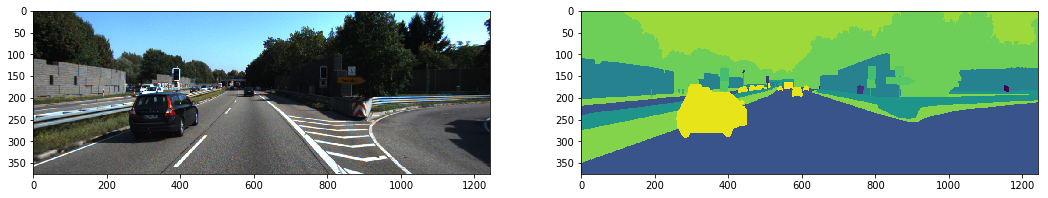

In [7]:
def show_semantic(image, semantic):
    """
    Show images with semantic segmentation
    Args:
        image(numpyarray): The training image
        semantic(numpyarray): The traing image semantic segmentation
    """
    
    
    plt.figure(figsize=(18, 3))
    plt.subplot(1,2,1)
    plt.imshow(image, aspect='auto')
    plt.subplot(1,2,2)
    plt.imshow(semantic, aspect='auto')
    plt.show()
    
# test the function

show_semantic(io.imread(os.path.join(train,image_ex)), 
              io.imread(os.path.join(train_mask,image_ex)))

### Define a TrainDataset class which includes the training images and the semantic segmentation of these images

In [8]:
class TrainDataset(Dataset):
    """Training dataset with mask image on gray scale/RGB"""
    def __init__(self, train_dir, semantic_dir, transform=None):
        """
        Args:
            train_dir (string): Directory with training images
            transform (callable): Optional transform to be applied on a sample
            semantic_dir (string): Directory with semantic segmentation training image
        """
        self.train_dir = train_dir
        self.transform = transform
        self.semantic_dir = semantic_dir
        
    def __len__(self):
        return len(os.listdir(self.train_dir))
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.train_dir, os.listdir(self.train_dir)[idx])
        semantic_name = os.path.join(self.semantic_dir, os.listdir(self.semantic_dir)[idx])
        image = io.imread(img_name)
        semantic = io.imread(semantic_name)
        sample = {'image':image, 'semantic':semantic}
        
        if self.transform:
            sample = self.transform(sample)
        return sample

0 (375, 1242, 3) (375, 1242)


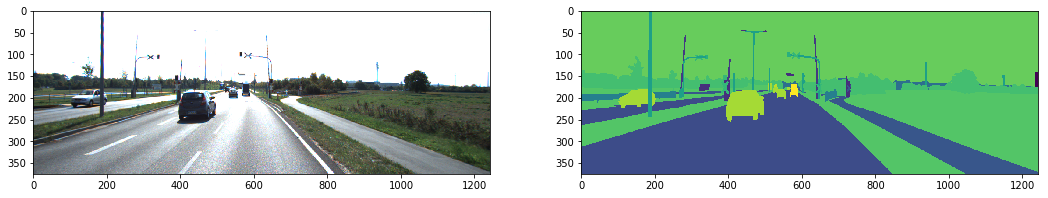

1 (375, 1242, 3) (375, 1242)


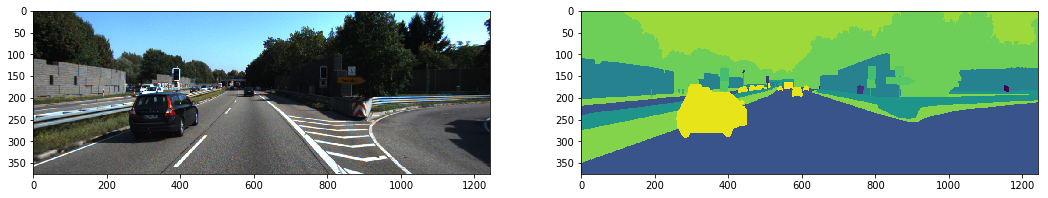

2 (375, 1242, 3) (375, 1242)


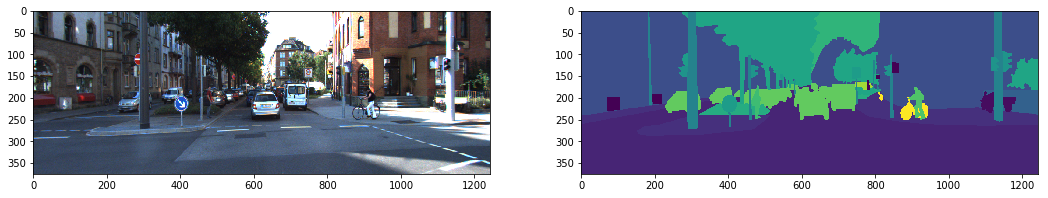

3 (375, 1242, 3) (375, 1242)


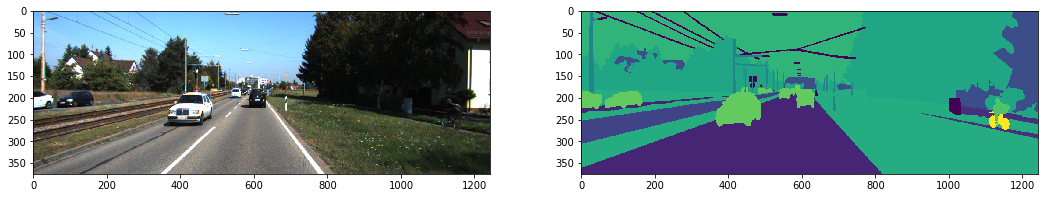

In [9]:
train_data = TrainDataset(train_dir=train, semantic_dir =train_mask)

for i in range(len(train_data)):
    sample = train_data[i]
    print(i, sample['image'].shape, sample['semantic'].shape)
    show_semantic(sample['image'],sample['semantic'])
    
    if i == 3:  
        break

In [10]:
class ToTensor(object):
    """Convert ndarrays in sample (both the original image 
    and the semantic image to Tensors"""
    
    def __call__(self, sample):
        image, semantic = sample['image'],sample['semantic']
        
        #swap color axis because
        #numpy image: H x W x C
        #torch image: C x H x W
        image = image.transpose((2, 0, 1))
        semantic = semantic
        return {'image': torch.from_numpy(image),
                'semantic': torch.from_numpy(semantic)}

In [11]:
class Rescale(object):
    """Rescale the image and the semantic image in sample to a given size.
    
    Args:
        output_h(int): Desired output height, both for image and semantic image
        output_w(int): Desired output width, both for image and semantic image
    """
    
    def __init__(self, new_h, new_w):
        self.new_h = new_h
        self.new_w = new_w
    
    def __call__(self, sample):
        image, semantic = sample['image'], sample['semantic']
        
        img = transform.resize(image,(self.new_h, self.new_w))
        semantic = transform.resize(semantic,(self.new_h, self.new_w))
        
        return{'image': img, 'semantic': semantic}

        

/home/xiaoyu/miniconda3/envs/deep_mol/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/xiaoyu/miniconda3/envs/deep_mol/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


<Figure size 432x288 with 0 Axes>

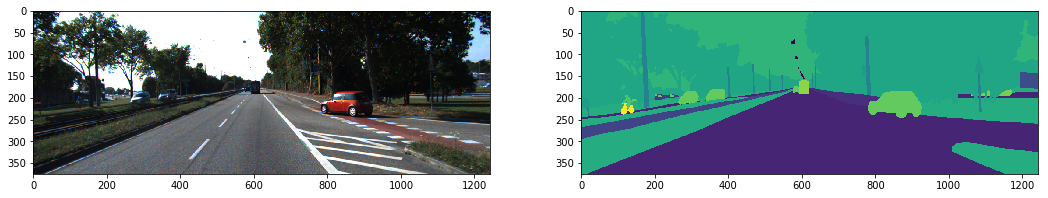

In [13]:
scale = Rescale(375,1242)
composed = transforms.Compose([Rescale(375,1242),ToTensor()])

fig = plt.figure()
sample = train_data[32]
transformed_sample = scale(sample)
show_semantic(**transformed_sample)

In [16]:
composed = transforms.Compose([Rescale(375,1242),ToTensor()])
transformed_dataset = TrainDataset(train_dir=train, semantic_dir =train_mask, transform = composed)

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    
    print(i, sample['image'].size(), sample['semantic'].size())
    
    if i == 3:
        break

print("Transformed_dataset is : " + str(type(transformed_dataset)))


0 torch.Size([3, 375, 1242]) torch.Size([375, 1242])
1 torch.Size([3, 375, 1242]) torch.Size([375, 1242])
2 torch.Size([3, 375, 1242]) torch.Size([375, 1242])
3 torch.Size([3, 375, 1242]) torch.Size([375, 1242])
Transformed_dataset is : <class '__main__.TrainDataset'>


In [17]:
dataloader = DataLoader(transformed_dataset, batch_size=1, shuffle = False, num_workers = 4)

In [18]:
# Helper function to show a batch
def show_semantic_batch(sample_batched):
    """Show original images and semantic images for a batch of samples"""
    images_batch, semantic_batch = \
            sample_batched['image'], sample_batched['semantic']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    
    grid = utils.make_grid(images_batch)
    plt.figure(figsize=(18, 3))
    plt.imshow(grid.numpy().transpose((1,2,0)))
 

0 torch.Size([1, 3, 375, 1242]) torch.Size([1, 375, 1242])
torch.float64
1 torch.Size([1, 3, 375, 1242]) torch.Size([1, 375, 1242])
torch.float64
2 torch.Size([1, 3, 375, 1242]) torch.Size([1, 375, 1242])
torch.float64
3 torch.Size([1, 3, 375, 1242]) torch.Size([1, 375, 1242])
torch.float64


<Figure size 432x288 with 0 Axes>

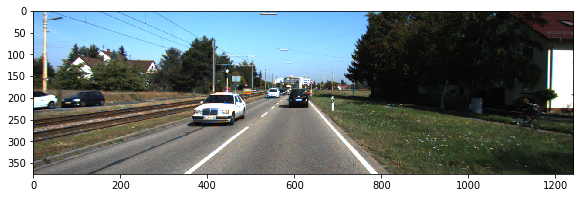

In [20]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(), sample_batched['semantic'].size())
    print(sample_batched['image'].dtype)
    #Observe the 4th batch and stop
    if i_batch == 3:
        plt.figure()
        show_semantic_batch(sample_batched)
        break
    

### Define the Unet

In [21]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2
    Args:
        in_ch: number of channels of the input
        out_ch: number of channels of the output
        inputsize (N, C_in, H, W) 
        outputsize (N, C_out, H_out, W_out)
        where N is the batch size, C is the number of channels
        kernel =3, stride =1, padding =0
        after the double_conv, the image size is decreased by 4 on each dimention
    '''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),  
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        
        x = self.conv(x)    
        return x

double_conv(
  (conv): Sequential(
    (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
  )
)
torch.Size([3, 3])
The first conv's weight is: torch.Size([1, 1, 3, 3])
The output size is: torch.Size([2, 1, 572, 572])


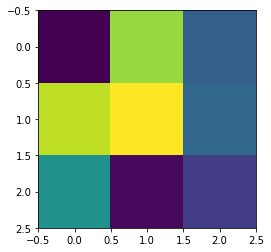

In [22]:
# test the double_conv
double_convnet = double_conv(1,1)
print(double_convnet)
input = torch.randn(2,1,572,572)
output = double_convnet(input)
double_convparams = list(double_convnet.parameters())
first_w = double_convparams[0].detach().squeeze()
print(first_w.size())
plt.imshow(first_w)
print("The first conv's weight is: "+str(double_convparams[0].size()))
print("The output size is: "+str(output.size()))

In [23]:
class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x

In [24]:
class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x

In [25]:
class up(nn.Module):
    """The algorithms available for upsampling are nearest neighbor and linear,
    bilinear and trilinear for 3D, 4D and 5D input Tensor, respectively."""
    
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)
            #Applies a 2D transposed convolution operator over an input image
            #composed of several input planes, sometimes also called “deconvolution”.

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


In [26]:
class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

In [27]:
class UNet(nn.Module):
    """
    Args:
        input channel(int)
        output channel(int)
    """
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return torch.sigmoid(x)

#### Unet parameters

In [28]:
unet = UNet(3,3).double()
#print(unet)
unet_params = list(unet.parameters())
#print(len(unet_params))
print(unet_params[0].size()) # conv1's weight  0.4.
# for m in range(64):
#     for n in range(3):
#         first_weight = unet_params[0].detach().squeeze()[m,n,:,:]
#         #print(first_weight.size())
#         plt.imshow(first_weight)
#         plt.pause(1)


torch.Size([64, 3, 3, 3])


In [29]:
unet = unet.cuda()

### Define a Loss function and optimizer

In [31]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.SGD(unet.parameters(), lr = 0.25, momentum = 0.9)

### Visualization before training

torch.Size([1, 3, 375, 1242])
torch.Size([1, 375, 1242])


/home/xiaoyu/miniconda3/envs/deep_mol/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


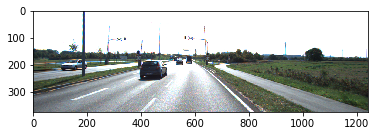

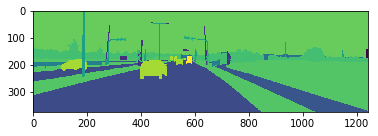

torch.Size([1, 3, 375, 1242])
torch.Size([3, 375, 1242])
torch.Size([375, 1242, 3])


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7faa04231cc0>>
Traceback (most recent call last):
  File "/home/xiaoyu/miniconda3/envs/deep_mol/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/xiaoyu/miniconda3/envs/deep_mol/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/xiaoyu/miniconda3/envs/deep_mol/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/xiaoyu/miniconda3/envs/deep_mol/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/xiaoyu/miniconda3/envs/deep_mol/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/xiaoyu/miniconda3/envs/

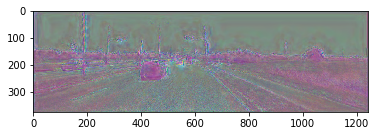

In [32]:
for i_batch, sample_batched in enumerate(dataloader):
    inputs, labels = sample_batched['image'], sample_batched['semantic']
    outputs = unet(inputs.cuda())
    print(inputs.size())
    print(labels.size())
    image_in = inputs.detach().squeeze().permute(1,2,0)
    image_mask = labels.detach().squeeze()
    plt.imshow(image_in)
    plt.pause(1)
    plt.imshow(image_mask)
    plt.pause(1)
    if i_batch == 0:
        print(outputs.size())
        image_out = outputs.detach().squeeze()
        print(image_out.size())
        print(image_out.permute(1, 2, 0).size())
        plt.imshow(image_out.permute(1, 2, 0))
        break

### Train the network

In [34]:
for epoch in range(1):
    # loop over the dataset 1 times
    # try to shuffle the datasets
    running_loss = 0.0
    for i_batch, sample_batched in enumerate(dataloader):
        #print(i_batch, sample_batched['image'].size(), sample_batched['semantic'].size())
        #get the inputs
        inputs, labels = sample_batched['image'], sample_batched['semantic']

        # put to GPU
        labels = labels.cuda().float()
        
        #zero the parameter gradients
        optimizer.zero_grad()
        
        #forward + backward +optimize
        outputs = unet(inputs.cuda())
        outputs.cuda()
        #print(outputs.size())
        
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()
        
        #print statistics
        running_loss += loss.item()
        if i_batch%20 ==19: 
            # print every 20 mini-batchs
            print('[%d, %5f] loss: %.3f'%(epoch +1, i_batch+1, running_loss/20))
            running_loss = 0.0
print('Finish Training')

[1, 20.000000] loss: 0.675
[1, 40.000000] loss: 0.552
[1, 60.000000] loss: 0.552
[1, 80.000000] loss: 0.552
[1, 100.000000] loss: 0.552
[1, 120.000000] loss: 0.552
[1, 140.000000] loss: 0.552
[1, 160.000000] loss: 0.552
Finish Training


torch.Size([1, 3, 375, 1242])
torch.Size([1, 375, 1242])


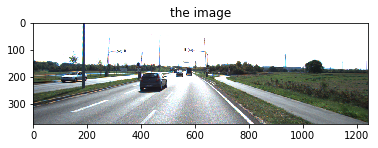

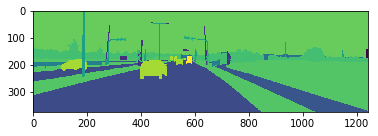

torch.Size([1, 3, 375, 1242])
torch.Size([3, 375, 1242])
torch.Size([375, 1242, 3])


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7faa04e01e80>>
Traceback (most recent call last):
  File "/home/xiaoyu/miniconda3/envs/deep_mol/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/xiaoyu/miniconda3/envs/deep_mol/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/xiaoyu/miniconda3/envs/deep_mol/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/xiaoyu/miniconda3/envs/deep_mol/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/xiaoyu/miniconda3/envs/deep_mol/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/xiaoyu/miniconda3/envs/

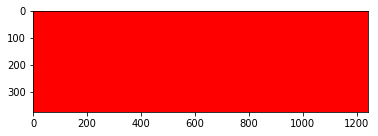

In [36]:
for i_batch, sample_batched in enumerate(dataloader):
    inputs, labels = sample_batched['image'], sample_batched['semantic']
    outputs = unet(inputs.cuda())
    print(inputs.size())
    print(labels.size())
    image_in = inputs.detach().squeeze().permute(1,2,0)
    image_mask = labels.detach().squeeze()
    plt.imshow(image_in)
    plt.title("the image")
    plt.pause(1)
    plt.imshow(image_mask)
    plt.pause(1)
    if i_batch == 0:
        print(outputs.size())
        image_out = outputs.detach().squeeze()
        print(image_out.size())
        print(image_out.permute(1, 2, 0).size())
        plt.imshow(image_out.permute(1, 2, 0))
        break